In [1]:
import os
import numpy as np
import shutil
# import os
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:1'#解决在epoch1时出现的未知问题

In [2]:
def read_img_path(file_path):
    path = os.listdir(file_path)
    path = [os.path.join(file_path,p) for p in path]
    return path
def build_remove(source,target):
    if not os.path.exists(target):
        os.mkdir(target)
        print("build target direction")
    for image in source:
        shutil.copy(image,target+'\\'+image.split("\\")[-1])
        
if __name__ == '__main__':
    os.chdir("..")
    #分到train和test中
    SOURCE_PATH = 'C:/mushroomdata/Mushrooms'
    resizeTrainAndTest = 'C:/mushroomdata/valAndTrain'
    if not os.path.exists(resizeTrainAndTest):
        os.mkdir(resizeTrainAndTest)
        print("build resizeTrainAndTest direction")
    TRAIN_PATH = os.path.join(resizeTrainAndTest,"train")
    VAL_PATH = os.path.join(resizeTrainAndTest,"val")
    #切换到训练夹目录下后
    if not os.path.exists(TRAIN_PATH):
        os.mkdir(TRAIN_PATH)
        print("build TRAIN_PATH direction")
    if not os.path.exists(VAL_PATH):
        os.mkdir(VAL_PATH)
        print("build TEST_PATH direction")
    for cur_path in os.listdir(SOURCE_PATH):
        cur =np.asarray(read_img_path(os.path.join(SOURCE_PATH,cur_path)))
        np.random.shuffle(cur)
        train = cur[:int(len(cur)*0.7)]
        val = cur[int(len(cur)*0.7):]
        #文件移动resizeTrainAndTest下的train和val中的norm和flaws
        build_remove(train,os.path.join(resizeTrainAndTest,'train',cur_path))
        build_remove(val,os.path.join(resizeTrainAndTest,'val',cur_path))

build TRAIN_PATH direction
build TEST_PATH direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction
build target direction


In [3]:
from keras.layers import GlobalAveragePooling2D
from keras.applications import vgg16,inception_v3,resnet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np
import h5py
from tqdm import tqdm
import os,cv2

Using TensorFlow backend.


In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Xception_wights='C:/mushroomdata/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
InceptionV3_wights='C:/mushroomdata/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_resnet_v2_wights='C:/mushroomdata/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_wights='C:/mushroomdata/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
VGG16_wights='C:/mushroomdata/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def white_gap(input_size,Models,lamda_func,name):
#     basic_model = Models(include_top = False,weights = 'imagenet')
    if name=='resnet50':
        basic_model = Models(weights=resnet50_wights, include_top=False)
    elif name=='vgg16':
        basic_model = Models(weights=VGG16_wights, include_top=False)
    elif name=='inception_v3':
        basic_model = Models(weights=InceptionV3_wights, include_top=False)
        
    feature = GlobalAveragePooling2D()(basic_model.output)
    model = Model(inputs = basic_model.input,outputs = feature)
    
    tra_gen = ImageDataGenerator(
#          rescale=1./255,
         featurewise_center=True,
         featurewise_std_normalization=True,
         rotation_range=20,
         width_shift_range=0.2,
         height_shift_range=0.2,
         horizontal_flip=True)
    
    v_gen = ImageDataGenerator()
    
    train_gen = tra_gen.flow_from_directory(r"C:\mushroomdata\valAndTrain\train",
                                        shuffle = False,batch_size = 16,
                                        class_mode = 'categorical',
                                        target_size = input_size,
#                                         interpolation='antialias',
                                         )
    for i in range(1):
        train_gen.next()
        
    val_gen = v_gen.flow_from_directory(r"C:\mushroomdata\valAndTrain\val",
                                        shuffle = False,batch_size = 16,
                                        class_mode = 'categorical',
                                        target_size = input_size,
#                                         interpolation='antialias',
                                        )
#     for i in range(1):
#         val_gen.next()
    #predict_generator中的steps是指预测多少个batch，即生成器生成多少次。train_gen.n是所有样本数
    ntrain_batch = int(np.ceil(train_gen.n/16.))
    train_feature = []
    train_labels = []
    #将hog值和特征一批一批的提取出来
    for e in tqdm(range(ntrain_batch)):
        (data,label) = train_gen.next()
        train_labels.append(label)
        data =lamda_func(data)
        feature = model.predict(data)
        #提取特征，加入train_feature中
        train_feature.append(feature)
        
    train_feature = np.concatenate(train_feature,axis = 0)
    train_labels = np.concatenate(train_labels)
    #nval_batch是val上batch的次数，用一个train_feature能指定内存，无需动态分配
    nval_batch = int(np.ceil(val_gen.n/16.))
    val_feature = []
    val_labels = []
    for e in tqdm(range(nval_batch)):
        (data,label) = val_gen.next()
        val_labels.append(label)
        data =lamda_func(data)
        feature = model.predict(data)
        val_feature.append(feature)
    
    val_feature = np.concatenate(val_feature,axis = 0)
    val_labels = np.concatenate(val_labels)
    
    dt = h5py.special_dtype(vlen = str)
    with h5py.File("C:/flower/multi_gap_%s.h5"%(name),'w') as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("val", data=val_feature)
#        h.create_dataset('test',data = test_feature)
        h.create_dataset("train_labels", data=train_labels)
        h.create_dataset("val_labels", data=val_labels)
os.chdir("..")
# white_gap((200,200),vgg16.VGG16,vgg16.preprocess_input,'vgg16')
white_gap((200,200),inception_v3.InceptionV3,inception_v3.preprocess_input,'inception_v3')
white_gap((200,200),resnet50.ResNet50,resnet50.preprocess_input,'resnet50')

Instructions for updating:
Colocations handled automatically by placer.
Found 4697 images belonging to 9 classes.


C:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2017 images belonging to 9 classes.


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [03:57<00:00,  1.37s/it]
C:\Anaconda\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 4697 images belonging to 9 classes.
Found 2017 images belonging to 9 classes.


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [08:37<00:00,  3.04s/it]


In [6]:
import h5py
import numpy as np
from sklearn.utils import shuffle
from keras.layers import Input,Dense,Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
#from train_with_feature import build_test
import os
os.chdir("..")
x_train,x_val=[],[]
model_list = ['inception_v3','resnet50']# ,'vgg16'

np.random.seed(100)
for modelName in model_list:
    with h5py.File("C:/flower/multi_gap_%s.h5"%(modelName),'r') as h:
        print(h["train"].shape)#
        print(h['train_labels'].shape)#
        print(h['val'].shape)#
        print(h['val_labels'].shape)#
        x_train.append(np.array(h["train"]))
        y_train = np.array(h['train_labels'])
        x_val.append(np.array(h['val']))
        y_val = np.array(h['val_labels'])
        
x_train = np.concatenate(x_train,axis = 1)
x_val = np.concatenate(x_val,axis = 1)
print(x_train.shape)
print(y_train.shape)#特征lable值
print(x_val.shape)
print(y_val.shape)#特征lable值
#x_test = np.concatenate(x_test,axis = 1)
#特征提取出来后随机打乱    
shuffle(x_train,y_train)
shuffle(x_val,y_val)

(4697, 2048)
(4697, 9)
(2017, 2048)
(2017, 9)
(4697, 2048)
(4697, 9)
(2017, 2048)
(2017, 9)
(4697, 4096)
(4697, 9)
(2017, 4096)
(2017, 9)


[array([[0.04970451, 0.2817775 , 0.13553712, ..., 0.465056  , 1.9239676 ,
         1.2585347 ],
        [0.52871424, 0.10387077, 1.4512004 , ..., 0.12563622, 3.4663272 ,
         1.0720317 ],
        [0.00901082, 0.9331006 , 0.4637312 , ..., 0.        , 0.94301355,
         2.9276333 ],
        ...,
        [0.22900288, 1.1964216 , 2.3736343 , ..., 0.0885327 , 0.10295395,
         5.0077906 ],
        [0.01328939, 0.0084381 , 0.22584765, ..., 0.20923793, 1.6411291 ,
         1.9162958 ],
        [0.07305406, 0.        , 0.27536568, ..., 0.        , 0.01272158,
         1.5498531 ]], dtype=float32), array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [7]:
import keras
from keras.layers import BatchNormalization
#构造图结构，函数化结构
inputs = Input((x_train.shape[1],))
x = BatchNormalization()(inputs, training=False)
x = Dense(512,activation = 'relu',
          kernel_initializer = 'TruncatedNormal')(x)
x = BatchNormalization()(x, training=False)
x = Dense(256,activation = 'relu',
          kernel_initializer = 'TruncatedNormal')(x)
outputs = Dense(9,activation = 'softmax',)(x)
model = Model(inputs = inputs,outputs = outputs)

from keras import optimizers
sgd = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = sgd,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [8]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [9]:
#开始训练
history=model.fit(x= x_train,y = y_train,validation_data = (x_val,y_val),verbose = 2,
          batch_size = 64,epochs = 30)
#计算最后模型的auc值
ypre_val = model.predict(x_val)
print('auc is :',roc_auc_score(y_val,ypre_val))
#导出预测文件
#ypre_test = model.predict(x_test)
#result = 1-ypre_test
#build_test(result.reshape(-1,).tolist(),Lname.tolist(),'result_multi_hog2.csv')

Instructions for updating:
Use tf.cast instead.
Train on 4697 samples, validate on 2017 samples
Epoch 1/30
 - 6s - loss: 1.7509 - acc: 0.4680 - val_loss: 1.0685 - val_acc: 0.6311
Epoch 2/30
 - 4s - loss: 0.8774 - acc: 0.6877 - val_loss: 0.9420 - val_acc: 0.6812
Epoch 3/30
 - 4s - loss: 0.6386 - acc: 0.7813 - val_loss: 0.9876 - val_acc: 0.6500
Epoch 4/30
 - 4s - loss: 0.5407 - acc: 0.8088 - val_loss: 0.9266 - val_acc: 0.6981
Epoch 5/30
 - 4s - loss: 0.3421 - acc: 0.8891 - val_loss: 0.8164 - val_acc: 0.7521
Epoch 6/30
 - 3s - loss: 0.2696 - acc: 0.9080 - val_loss: 0.9833 - val_acc: 0.7194
Epoch 7/30
 - 3s - loss: 0.1881 - acc: 0.9408 - val_loss: 0.9776 - val_acc: 0.7437
Epoch 8/30
 - 3s - loss: 0.1427 - acc: 0.9553 - val_loss: 0.9568 - val_acc: 0.7467
Epoch 9/30
 - 3s - loss: 0.0770 - acc: 0.9791 - val_loss: 1.1418 - val_acc: 0.7184
Epoch 10/30
 - 3s - loss: 0.0785 - acc: 0.9738 - val_loss: 1.0869 - val_acc: 0.7432
Epoch 11/30
 - 3s - loss: 0.0460 - acc: 0.9891 - val_loss: 1.1814 - val_a

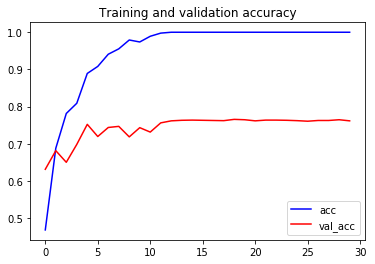

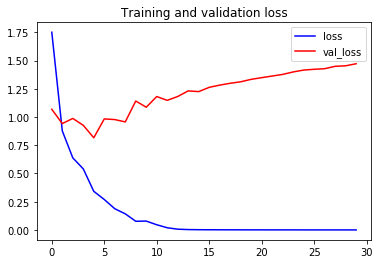

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
matplotlib.use('Qt5Agg') 
from matplotlib import pyplot as plt
%matplotlib inline

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.legend(["acc", "val_acc"], loc='best')
    plt.title('Training and validation accuracy')
    plt.show()
    loss = history.history['loss']
    val_loss = history.history['val_loss']   
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.legend(["loss", "val_loss"], loc='best')
    plt.title('Training and validation loss')
    plt.show()

plot_training(history)